# Simple synthetics

Normal incidence and offset synthetics, with minimum code.

I'd used 'real world' quantities, which makes it hard to have a small model, because otherwise the wavelet has to be unreaonably high frequency.

Steps:

- Make an earth model in depth, focusing on velocities.
- Convert the earth model to time.
- Compute the reflectivity coefficient series, `rc`.
- Add noise, if desired.
- Make a wavelet.
- Convolve `rc` with the wavelet.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Earth model

We'll make Vp then fudge everything else based on that.

In [2]:
size = 200
depth = 0.1524 * np.arange(size)

vp = np.ones_like(depth) * 1486
vp[size//3:] = 2000
vp[2 * size//3:] = 2200

vs = vp / 2   # or use ones, doesn't matter for normal incidence
rho = np.ones_like(vp)   # or use bruges.petrophysics.gardner()

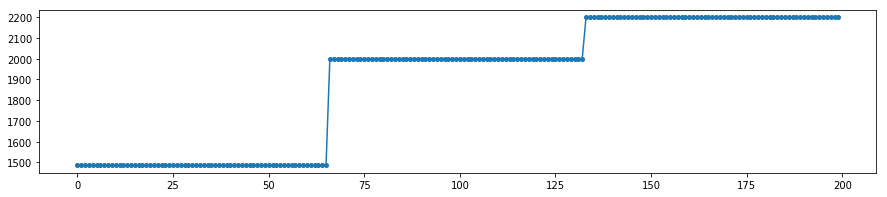

In [3]:
plt.figure(figsize=(15, 3))
plt.plot(vp, 'o-', ms=4)

### Convert to time

In [4]:
# Intervals
dz = depth[1] - depth[0]
dt = 0.0001   # 0.1 ms

# Recorded time
cumt = np.cumsum(dz / vp)

# Target time basis
t = np.arange(0, cumt[-1], dt)

# Converted logs
vp_t = np.interp(t, cumt, vp)
vs_t = np.interp(t, cumt, vs)
rho_t = np.interp(t, cumt, rho)

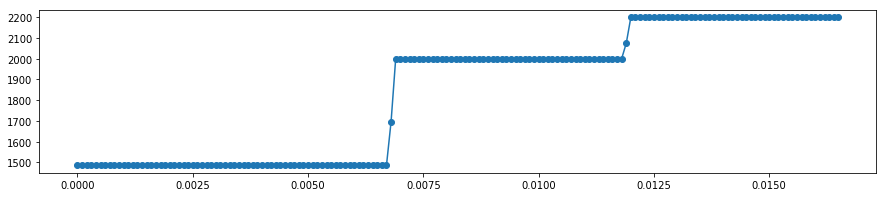

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(t, vp_t, 'o-')

### Compute reflection coefficients

/home/matt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<StemContainer object of 3 artists>

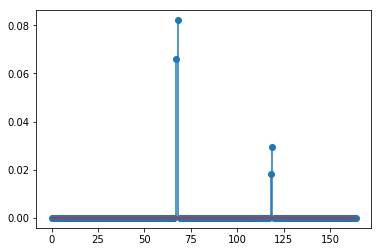

In [6]:
import bruges

rc = bruges.reflection.reflectivity(vp_t, vs_t, rho_t, theta=0)

plt.stem(rc)

### Add noise

In [7]:
def add_noise(rc, snr):
    """
    Add noise to `rc` with signal:noise ratio `snr`.
    
    The SNR is not really SNR, it's just a way to scale the max noise
    spikes relative to the mean RC spike size.
    """
    sig = np.mean(rc[rc > 0], axis=-1)  # Only measure the spikes, seems more intuitive
    return rc + (np.random.random(size=rc.shape)-0.5) * 2 * sig / snr

/home/matt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<StemContainer object of 3 artists>

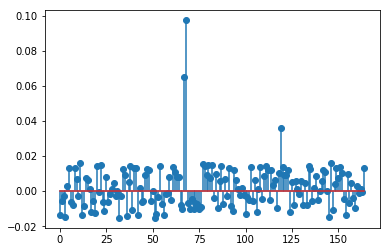

In [8]:
rc_ = add_noise(rc, snr=3)

plt.stem(rc_)

### Wavelet

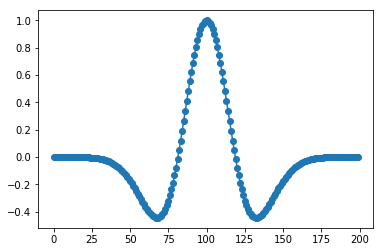

In [9]:
w = bruges.filters.ricker(0.02, dt, 120)

plt.plot(w, 'o-')

### Convolve

In [10]:
syn = np.convolve(rc_, w, mode='same')

/home/matt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


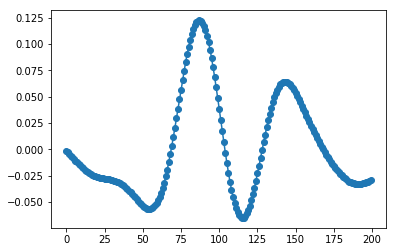

In [11]:
plt.plot(syn, 'o-')

# Offset reflectivity

### Make RC and add noise

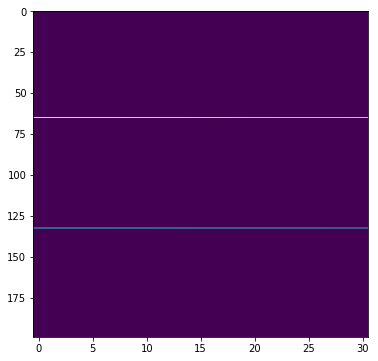

In [12]:
rc = bruges.reflection.reflectivity(vp, vs, rho, theta=np.arange(0, 31))

plt.figure(figsize=(6, 6))
plt.imshow(rc.real.T, aspect='auto')

In [13]:
rc_ = add_noise(rc, snr=3)

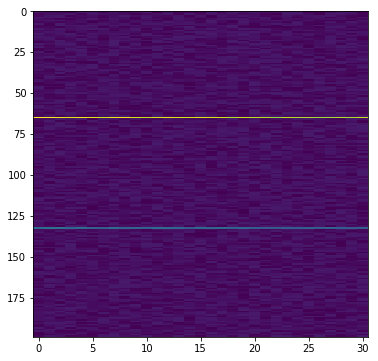

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(rc_.real.T, aspect='auto')

### Smooth laterally

This makes a more reasonable-looking synthetic.

In [15]:
from functools import partial

In [16]:
kernel = [0.1, 0.333, 1.0, 0.333, 0.1]
func = partial(np.convolve, v=kernel, mode='same')

rc_ = np.apply_along_axis(func, axis=0, arr=rc_)

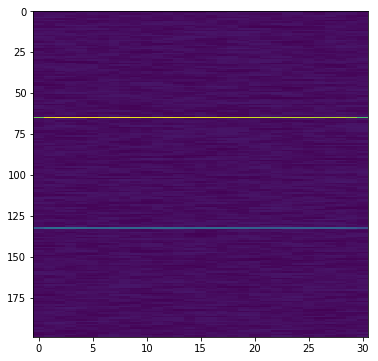

In [17]:
plt.figure(figsize=(6, 6))
plt.imshow(rc_.real.T, aspect='auto')

### Convolution

In [18]:
func = partial(np.convolve, v=w, mode='same')

syn = np.apply_along_axis(func, axis=1, arr=rc_)

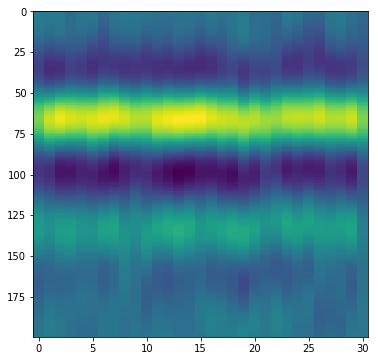

In [19]:
plt.figure(figsize=(6, 6))
plt.imshow(syn.real.T, aspect='auto')